1. Importing Libraries

In [5]:

import os
import pandas as pd
import numpy as np
import math
import datetime as dt

import matplotlib.pyplot as plt
import seaborn as sns

import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots

from sklearn.metrics import mean_squared_error, mean_absolute_error, explained_variance_score, r2_score
from sklearn.metrics import mean_poisson_deviance, mean_gamma_deviance
from sklearn.preprocessing import MinMaxScaler

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, GRU

from google.colab import files

2. Load and Preprocess the Data

In [6]:
uploaded = files.upload()
# Upload file
file_name = list(uploaded.keys())[0]

# Read csv
df = pd.read_csv(file_name)
df.rename(columns={'Date': 'date', 'Open': 'open', 'High': 'high', 'Low': 'low',
                   'Close': 'close', 'Adj Close': 'adj_close', 'Volume': 'volume'}, inplace=True)

# Display the first few rows
df.head()

# Check for missing or NA values
print("Total missing values:", df.isnull().sum().sum())
print("Any NA values:", df.isna().any().any())

# Convert 'date' column to datetime type
df['date'] = pd.to_datetime(df['date'])

Saving TSLA.csv to TSLA.csv
Total missing values: 0
Any NA values: False


3. Exploratory Data Analysis (EDA)

In [7]:
# Print basic info about the dataset
print("Dataset start date:", df['date'].min())
print("Dataset end date:", df['date'].max())
print("Total duration:", df['date'].max() - df['date'].min())
print("Dataset shape:", df.shape)

# Plot a multi-line chart of Open, Close, High, and Low prices
fig = go.Figure()
fig.add_trace(go.Scatter(x=df['date'], y=df['open'], mode='lines', name='Open Price'))
fig.add_trace(go.Scatter(x=df['date'], y=df['close'], mode='lines', name='Close Price'))
fig.add_trace(go.Scatter(x=df['date'], y=df['high'], mode='lines', name='High Price'))
fig.add_trace(go.Scatter(x=df['date'], y=df['low'], mode='lines', name='Low Price'))

fig.update_layout(title='Stock Prices Over Time',
                  xaxis_title='Date',
                  yaxis_title='Price',
                  template='plotly_white')
fig.show()

Dataset start date: 2016-08-16 00:00:00
Dataset end date: 2021-08-13 00:00:00
Total duration: 1823 days 00:00:00
Dataset shape: (1258, 7)


4. Additional EDA: Candlestick Chart, Monthly Averages, and Correlation Heatmap

                 open       close
month                            
January    211.862118  212.589568
February   227.558569  227.040441
March      194.185782  193.161236
April      205.595030  205.671611
May        181.159451  180.826095
June       204.369197  204.726543
July       226.404302  226.023074
August     173.212144  174.174936
September  129.064456  128.870416
October    129.469280  128.815189
November   137.678000  137.957262
December   183.599535  185.258544


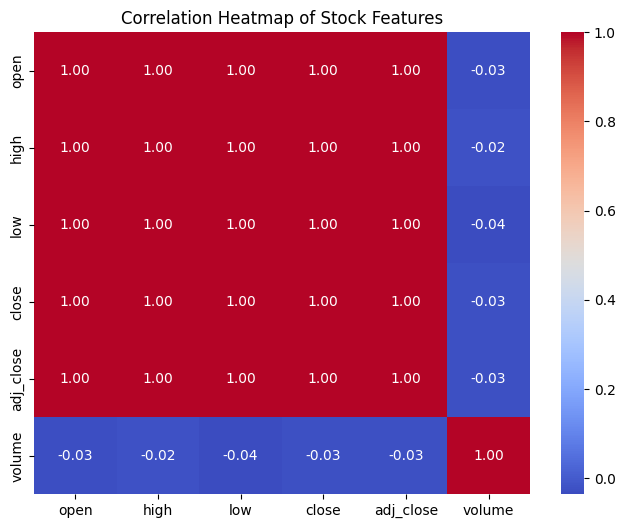

In [8]:
# Candlestick Chart
fig = go.Figure(data=[go.Candlestick(x=df['date'],
                                     open=df['open'],
                                     high=df['high'],
                                     low=df['low'],
                                     close=df['close'],
                                     name='Candlestick')])
fig.update_layout(title='Candlestick Chart of Stock Prices',
                  xaxis_title='Date',
                  yaxis_title='Price',
                  template='plotly_white')
fig.show()

# Month-wise Average Open and Close Prices
df['month'] = df['date'].dt.strftime('%B')
monthly_avg = df.groupby('month')[['open', 'close']].mean()

# Reorder months
month_order = ['January', 'February', 'March', 'April', 'May', 'June',
               'July', 'August', 'September', 'October', 'November', 'December']
monthly_avg = monthly_avg.reindex(month_order)
print(monthly_avg)

fig = go.Figure()
fig.add_trace(go.Bar(x=monthly_avg.index, y=monthly_avg['open'], name='Avg Open Price', marker_color='teal'))
fig.add_trace(go.Bar(x=monthly_avg.index, y=monthly_avg['close'], name='Avg Close Price', marker_color='coral'))
fig.update_layout(barmode='group',
                  title='Monthly Average Open and Close Prices',
                  xaxis_tickangle=-45,
                  template='plotly_white')
fig.show()

# Correlation Heatmap
plt.figure(figsize=(8,6))
corr = df[['open', 'high', 'low', 'close', 'adj_close', 'volume']].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap of Stock Features')
plt.show()

5. Feature Engineering: Compute Technical Indicators

In [9]:
# Function to calculate Relative Strength Index (RSI)
def compute_RSI(series, period=14):
    delta = series.diff()
    up = delta.clip(lower=0)
    down = -1 * delta.clip(upper=0)
    # Calculate rolling means of gains and losses
    ma_up = up.rolling(window=period, min_periods=period).mean()
    ma_down = down.rolling(window=period, min_periods=period).mean()
    rs = ma_up / ma_down
    rsi = 100 - (100 / (1 + rs))
    return rsi

# Compute RSI on the 'close' price
df['RSI'] = compute_RSI(df['close'], period=14)

# Calculate MACD: Difference between 12-day EMA and 26-day EMA, plus the signal line (9-day EMA of MACD)
df['EMA12'] = df['close'].ewm(span=12, adjust=False).mean()
df['EMA26'] = df['close'].ewm(span=26, adjust=False).mean()
df['MACD'] = df['EMA12'] - df['EMA26']
df['Signal_Line'] = df['MACD'].ewm(span=9, adjust=False).mean()

# Compute Bollinger Bands (20-day SMA and 2 standard deviations)
df['SMA20'] = df['close'].rolling(window=20).mean()
df['STD20'] = df['close'].rolling(window=20).std()
df['Upper_Band'] = df['SMA20'] + (2 * df['STD20'])
df['Lower_Band'] = df['SMA20'] - (2 * df['STD20'])

# Show the latest values of the new features
df[['date', 'close', 'RSI', 'MACD', 'Signal_Line', 'SMA20', 'Upper_Band', 'Lower_Band']].tail()

,date,close,RSI,MACD,Signal_Line,SMA20,Upper_Band,Lower_Band
1253,2021-08-09,713.760010,68.462290,16.331698,11.721335,672.156992,727.383357,616.930626
1254,2021-08-10,709.989990,69.152667,16.593019,12.695672,674.229492,731.939506,616.519478
1255,2021-08-11,707.820007,71.073843,16.435560,13.443649,676.951492,735.647952,618.255033
1256,2021-08-12,722.250000,76.737406,17.276006,14.210121,680.533994,741.172559,619.895428
1257,2021-08-13,717.169983,71.524608,17.332353,14.834567,684.181494,744.397459,623.965529


6. Plot Technical Indicators

In [10]:

# RSI Plot
fig = go.Figure()
fig.add_trace(go.Scatter(x=df['date'], y=df['RSI'], mode='lines', name='RSI'))
fig.update_layout(title='Relative Strength Index (RSI)',
                  xaxis_title='Date',
                  yaxis_title='RSI Value',
                  template='plotly_white')
# Add overbought and oversold thresholds
fig.add_hline(y=70, line_dash="dash", line_color="red")
fig.add_hline(y=30, line_dash="dash", line_color="green")
fig.show()

# MACD and Signal Line Plot
fig = go.Figure()
fig.add_trace(go.Scatter(x=df['date'], y=df['MACD'], mode='lines', name='MACD', line=dict(color='blue')))
fig.add_trace(go.Scatter(x=df['date'], y=df['Signal_Line'], mode='lines', name='Signal Line', line=dict(color='orange')))
fig.update_layout(title='MACD and Signal Line',
                  xaxis_title='Date',
                  yaxis_title='Value',
                  template='plotly_white')
fig.show()

# -- Bollinger Bands Plot --
fig = go.Figure()
fig.add_trace(go.Scatter(x=df['date'], y=df['close'], mode='lines', name='Close Price'))
fig.add_trace(go.Scatter(x=df['date'], y=df['Upper_Band'], mode='lines', name='Upper Bollinger Band', line=dict(color='red')))
fig.add_trace(go.Scatter(x=df['date'], y=df['Lower_Band'], mode='lines', name='Lower Bollinger Band', line=dict(color='green')))
fig.add_trace(go.Scatter(x=df['date'], y=df['SMA20'], mode='lines', name='20-Day SMA', line=dict(color='orange')))
fig.update_layout(title='Bollinger Bands and 20-Day SMA',
                  xaxis_title='Date',
                  yaxis_title='Price',
                  template='plotly_white')
fig.show()

7. Prepare Data for Forecasting

In [11]:


# Consider only the last 1 year of data
start_date = df['date'].max() - pd.DateOffset(years=1)
df_last_year = df[df['date'] > start_date].copy()
df_last_year.reset_index(drop=True, inplace=True)
print("Data points for prediction:", df_last_year.shape[0])

# Plot the closing price for the selected period
fig = go.Figure()
fig.add_trace(go.Scatter(x=df_last_year['date'], y=df_last_year['close'], mode='lines',
                         name='Close Price', line=dict(color='purple')))
fig.update_layout(title='Closing Price (Last 1 Year)',
                  xaxis_title='Date',
                  yaxis_title='Price',
                  template='plotly_white')
fig.show()

# Select Features for the Model
# I use 'close', 'RSI', and 'MACD' as inputs. (Ensure to drop rows with NaN.)
model_df = df_last_year[['close', 'RSI', 'MACD']].dropna().reset_index(drop=True)
model_df.head()

# -- Scale the Features and Target Separately --
scaler_features = MinMaxScaler(feature_range=(0, 1))
scaler_target = MinMaxScaler(feature_range=(0, 1))

features = model_df[['close', 'RSI', 'MACD']]
target = model_df['close'].values.reshape(-1, 1)

features_scaled = scaler_features.fit_transform(features)
target_scaled = scaler_target.fit_transform(target)

Data points for prediction: 252


8: Create Time-Series Dataset for Modeling

In [12]:


def create_sequences(data, target, time_steps=15):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i: i + time_steps])
        y.append(target[i + time_steps])
    return np.array(X), np.array(y)

time_steps = 15
X, y = create_sequences(features_scaled, target_scaled, time_steps)

print("Input data shape (samples, time_steps, features):", X.shape)
print("Target data shape:", y.shape)

# Split into training and testing datasets (using a 60:40 split)
train_size = int(len(X) * 0.6)
X_train = X[:train_size]
y_train = y[:train_size]
X_test = X[train_size:]
y_test = y[train_size:]

print("Training set shape:", X_train.shape, y_train.shape)
print("Testing set shape:", X_test.shape, y_test.shape)

Input data shape (samples, time_steps, features): (237, 15, 3)
Target data shape: (237, 1)
Training set shape: (142, 15, 3) (142, 1)
Testing set shape: (95, 15, 3) (95, 1)


9. Build and Train the GRU Model

In [13]:

tf.keras.backend.clear_session()

model = Sequential()
model.add(GRU(32, return_sequences=True, input_shape=(time_steps, X_train.shape[2])))
model.add(GRU(32, return_sequences=True))
model.add(GRU(32))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

model.summary()

# Train the model
history = model.fit(X_train, y_train,
                    validation_data=(X_test, y_test),
                    epochs=200,
                    batch_size=32,
                    verbose=1)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ gru (GRU)                            │ (None, 15, 32)              │           3,552 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_1 (GRU)                          │ (None, 15, 32)              │           6,336 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_2 (GRU)                          │ (None, 32)                  │           6,336 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 16,257 (63.50 KB)

 Trainable params: 16,257 (63.50 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 7s 436ms/step - loss: 0.3452 - val_loss: 0.1090
Epoch 2/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0941 - val_loss: 0.0077
Epoch 3/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0823 - val_loss: 0.0066
Epoch 4/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0611 - val_loss: 0.0279
Epoch 5/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0489 - val_loss: 0.0264
Epoch 6/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0351 - val_loss: 0.0056
Epoch 7/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0226 - val_loss: 0.0036
Epoch 8/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0208 - val_loss: 0.0027
Epoch 9/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0164 - val_loss: 0.0028
Epoch 10/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0135 - val_loss: 0.0060
Epoch 11/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0151 - val_loss: 0.0027
Epoch 12/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0079 - val_l

10. Plot Training and Validation Loss

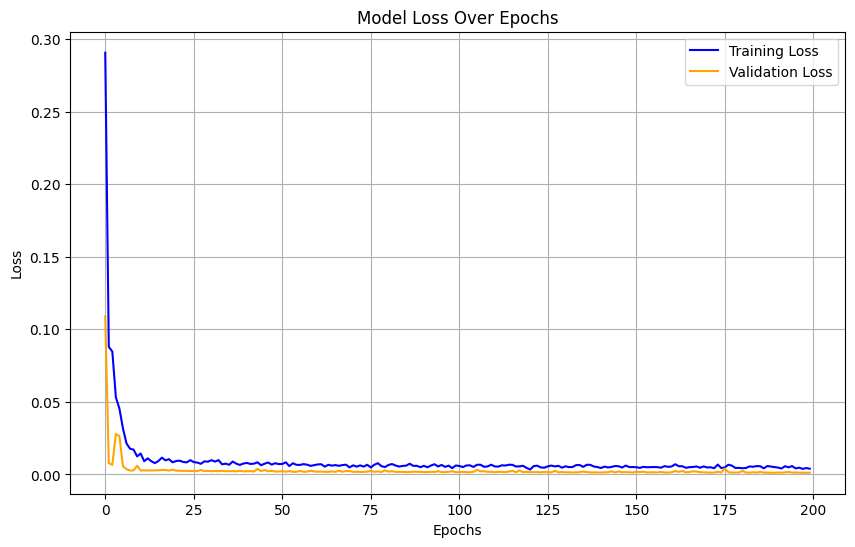

In [14]:

plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss', color='blue')
plt.plot(history.history['val_loss'], label='Validation Loss', color='orange')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

11. Evaluate the Model

In [15]:


# Generate predictions for training and test sets
train_predictions = model.predict(X_train)
test_predictions = model.predict(X_test)

# Inverse transform predictions and true values (only for the target 'close' price)
train_predictions_inv = scaler_target.inverse_transform(train_predictions)
y_train_inv = scaler_target.inverse_transform(y_train)
test_predictions_inv = scaler_target.inverse_transform(test_predictions)
y_test_inv = scaler_target.inverse_transform(y_test)

# Compute evaluation metrics
train_rmse = math.sqrt(mean_squared_error(y_train_inv, train_predictions_inv))
test_rmse = math.sqrt(mean_squared_error(y_test_inv, test_predictions_inv))
train_mae = mean_absolute_error(y_train_inv, train_predictions_inv)
test_mae = mean_absolute_error(y_test_inv, test_predictions_inv)

print("Train RMSE:", train_rmse)
print("Train MAE:", train_mae)
print("Test RMSE:", test_rmse)
print("Test MAE:", test_mae)

print("Train Explained Variance:", explained_variance_score(y_train_inv, train_predictions_inv))
print("Test Explained Variance:", explained_variance_score(y_test_inv, test_predictions_inv))
print("Train R2 Score:", r2_score(y_train_inv, train_predictions_inv))
print("Test R2 Score:", r2_score(y_test_inv, test_predictions_inv))

print("Train Mean Gamma Deviance:", mean_gamma_deviance(y_train_inv, train_predictions_inv))
print("Test Mean Gamma Deviance:", mean_gamma_deviance(y_test_inv, test_predictions_inv))
print("Train Mean Poisson Deviance:", mean_poisson_deviance(y_train_inv, train_predictions_inv))
print("Test Mean Poisson Deviance:", mean_poisson_deviance(y_test_inv, test_predictions_inv))

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Train RMSE: 27.369315899571987
Train MAE: 21.015271067286527
Test RMSE: 18.984149586084072
Test MAE: 14.508335491776315
Train Explained Variance: 0.9727563826122821
Test Explained Variance: 0.8409990450438206
Train R2 Score: 0.9717314880545235
Test R2 Score: 0.8378218731802195
Train Mean Gamma Deviance: 0.0024109899251862814
Test Mean Gamma Deviance: 0.0008263069071286401
Train Mean Poisson Deviance: 1.2971527338081503
Test Mean Poisson Deviance: 0.544405263556844


12. Compare Actual vs. Predicted Close Prices

In [16]:

test_dates = df_last_year['date'].iloc[-len(y_test):].reset_index(drop=True)
comparison_df = pd.DataFrame({
    'date': test_dates,
    'Actual_Close': y_test_inv.flatten(),
    'Predicted_Close': test_predictions_inv.flatten()
})

fig = go.Figure()
fig.add_trace(go.Scatter(x=comparison_df['date'], y=comparison_df['Actual_Close'],
                         mode='lines', name='Actual Close', line=dict(color='green')))
fig.add_trace(go.Scatter(x=comparison_df['date'], y=comparison_df['Predicted_Close'],
                         mode='lines', name='Predicted Close', line=dict(color='red')))
fig.update_layout(title='Actual vs. Predicted Close Prices (Test Set)',
                  xaxis_title='Date',
                  yaxis_title='Price',
                  template='plotly_white')
fig.show()

13. Forecast the Next 5 Days

In [18]:

forecast_steps = 5
# Get the last 'time_steps' rows from the features (scaled) to form the initial window.
last_window = features_scaled[-time_steps:]  # shape: (time_steps, num_features)
forecast_input = last_window.copy()

forecast_predictions = []
for i in range(forecast_steps):
    # Reshape input to match model expectation: (1, time_steps, features)
    forecast_input_reshaped = forecast_input.reshape(1, time_steps, X_train.shape[2])
    pred_scaled = model.predict(forecast_input_reshaped, verbose=0)
    forecast_predictions.append(pred_scaled[0, 0])

    # Create a new row: update the 'close' value with the prediction and keep RSI & MACD as last known values.
    last_row = forecast_input[-1].copy()
    new_row = last_row.copy()
    new_row[0] = pred_scaled[0, 0]  # Update close with predicted value
    # Optionally, more sophisticated methods could update RSI and MACD.

    # Slide the window: remove the first row and append the new row.
    forecast_input = np.vstack([forecast_input[1:], new_row])

# Inverse transform the forecast predictions for the close price
forecast_predictions = np.array(forecast_predictions).reshape(-1, 1)
forecast_predictions_inv = scaler_target.inverse_transform(forecast_predictions)

# Generate future dates for plotting
last_date = df_last_year['date'].iloc[-1]
future_dates = [last_date + dt.timedelta(days=i + 1) for i in range(forecast_steps)]

# Plot the historical closing price along with the forecast
fig = go.Figure()
fig.add_trace(go.Scatter(x=df_last_year['date'], y=df_last_year['close'], mode='lines',
                         name='Historical Close'))
fig.add_trace(go.Scatter(x=future_dates, y=forecast_predictions_inv.flatten(), mode='lines',
                         name='Forecasted Close', line=dict(color='red')))
fig.update_layout(title='Forecast for Next 5 Days',
                  xaxis_title='Date',
                  yaxis_title='Close Price',
                  template='plotly_white')
fig.show()